#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Differential Equations

We now consider the problem of computing $y(t)$ from an *ordinary differential equation* (ODE)

$$ y'(t) = f(t,y) $$

and initial condition $y(0)$.
In the following, $y$ may be a scalar or vector value.
For convenience of notation, we may suppress the time dependence by writing $y$ instead of $y(t)$.

### Second Order Equations

A second order system such as

$$ y'' = f(t, y, y') $$

may always be converted to a first order system by introducing a new variable

$$ \begin{bmatrix} y_0 \\ y_1 \end{bmatrix}' = \begin{bmatrix} y_1 \\ f(t, y_0, y_1) \end{bmatrix} . $$
Therefore, without loss of generality, we will focus on first order systems.

### Implicit formulations

We have chosen the explicit representation $y' = f(t,y)$, but it is more general to write $h(t,y,y') = 0$.
If $\partial h/\partial y'$ is singular, then this describes a *differential algebraic equation* (DAE).  DAE are more challenging to solve and beyond the scope of this course.

## Linear Equations

If $f(y,t)$ is a linear function of $y$ then we have a linear ODE
$$ y' = A(t) y + \text{source}(t) . $$
If $A(t)$ is independent of $t$ and $\text{source}(t) = 0$ then we have a linear, constant, autonomous ODE.

When $y$ is a scalar then $A = a$ is a scalar and the solution is
$$ y = y(0) e^{at} . $$

#### Question
What qualitative dynamics does this imply for
* $a > 0$?
* $a < 0$?
* $a$ imaginary?

#### Question
* What if $A$ is diagonal?
* What if $A = X \Lambda X^{-1}$?

#### Matrix exponential
The general solution can be written in terms of the matrix exponential.
$$ y(t) = e^{At} y(0) . $$
The matrix exponential is defined by its Taylor series
$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are many [practical ways to compute it](http://www.cs.cornell.edu/cv/ResearchPDF/19ways+.pdf).

#### Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

## Forward Euler Method

The simplest method for solving $y'(t) = f(t,y)$ is
$$ \tilde y(h) = y(0) + h f(0, y(0)) . $$

In [1]:
%matplotlib notebook
import numpy
from matplotlib import pyplot

def ode_euler(f, y0, tfinal=1, h=0.1):
    y = numpy.array(y0)
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        h = min(h, tfinal - t)
        y += h * f(t, y)
        t += h
        thist.append(t)
        yhist.append(y.copy())
    return numpy.array(thist), numpy.array(yhist)

tests = []

class cosine:
    def __init__(self, k=5):
        self.k = k
    def __repr__(self):
        return 'cosine(k={:d})'.format(self.k)
    def f(self, t, y):
        return -self.k * (y - numpy.cos(t))
    def y(self, t, y0):
        k2p1 = self.k**2+1
        return (y0 - self.k**2/k2p1) * numpy.exp(-self.k*t) + self.k*(numpy.sin(t) + self.k*numpy.cos(t))/k2p1

tests.append(cosine(k=3))
tests.append(cosine(k=20))    

<IPython.core.display.Javascript object>


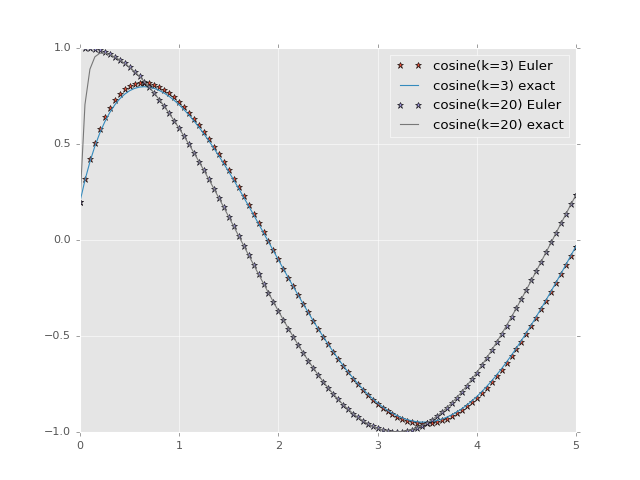

In [2]:
pyplot.style.use('ggplot')
pyplot.rcParams['figure.max_open_warning'] = False

y0 = .2
for test in tests:
    thist, yhist = ode_euler(test.f, y0, h=.05, tfinal=5)
    pyplot.plot(thist, yhist, '*', label=repr(test)+' Euler')
    pyplot.plot(thist, test.y(thist, y0), label=repr(test)+' exact')
pyplot.legend(loc='upper right')

#### Question

* What happens when $h$ is increased?

<IPython.core.display.Javascript object>


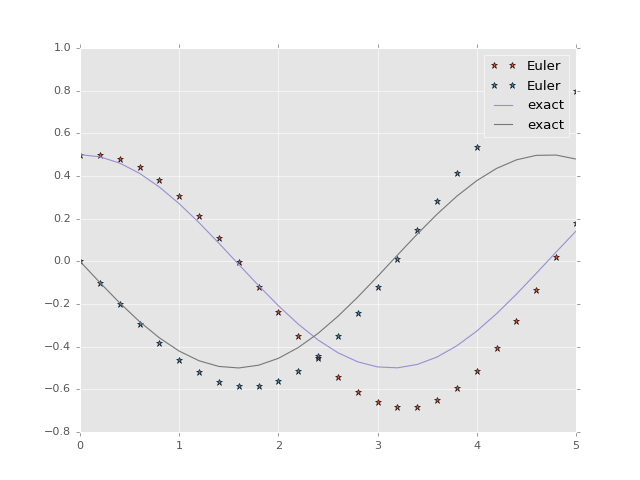

In [3]:
def expm(A):
    """Compute the matrix exponential"""
    L, X = numpy.linalg.eig(A)
    return X.dot(numpy.diag(numpy.exp(L))).dot(numpy.linalg.inv(X))

class linear:
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, y):
        return self.A.dot(y)
    def y(self, t, y0):
        return [numpy.real(expm(self.A*s).dot(y0)) for s in t]

test = linear(numpy.array([[0, 1],[-1, 0]]))
y0 = numpy.array([.5, 0])
thist, yhist = ode_euler(test.f, y0, h=.2, tfinal=5)
pyplot.figure()
pyplot.plot(thist, yhist, '*', label='Euler')
pyplot.plot(thist, test.y(thist, y0), label='exact')
pyplot.legend(loc='upper right')

#### Questions
* Does shrinking $h$ make this more accurate?
* What if `tfinal` is extended?
* What are the eigenvalues of $A$?

<IPython.core.display.Javascript object>


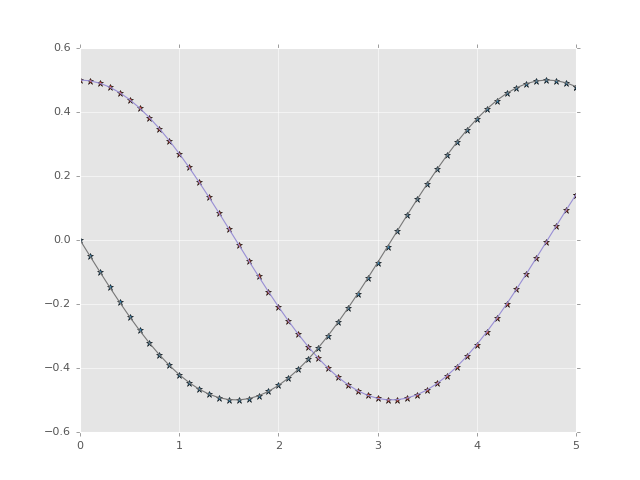

In [4]:
def ode_rk4(f, y0, tfinal=1, h=0.1):
    y = y0.copy()
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        h = min(h, tfinal - t)
        k1 = f(t, y)
        k2 = f(t+h/2, y + k1*h/2)
        k3 = f(t+h/2, y + k2*h/2)
        k4 = f(t+h, y + k3*h)
        y += h/6 * (k1 + 2*k2 + 2*k3 + k4)
        t += h
        thist.append(t)
        yhist.append(y.copy())
    return numpy.array(thist), numpy.array(yhist)

thist, yhist = ode_rk4(test.f, y0, h=.1, tfinal=5)
pyplot.figure()
pyplot.plot(thist, yhist, '*', label=repr(test)+' RK4')
pyplot.plot(thist, test.y(thist, y0), label=repr(test)+' exact')

### Linear Stability Analysis

Why did Euler diverge (even if slowly) while RK4 solved this problem accurately?
And why do both methods diverge if the step size is too large?
We can understand the convergence of methods by analyzing the test problem
$$ y' = \lambda y $$
for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps
$$ y \to y + h \lambda y = (1 + h \lambda) y =: R(h \lambda) y $$
where we have introduced the complex-valued function $R(z)$.

* When is this map stable?

<IPython.core.display.Javascript object>


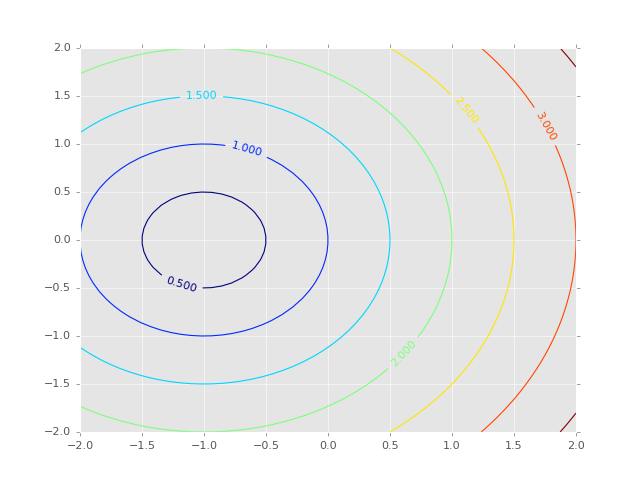

<a list of 6 text.Text objects>

In [5]:
pyplot.figure()
x = numpy.linspace(-2,2)
xx, yy = numpy.meshgrid(x, x)
zz = xx + 1j*yy
R = 1 + zz
C = pyplot.contour(xx, yy, numpy.abs(R))
pyplot.clabel(C)